Found 99 .mat files.
Keys inside the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'data', 'fs', 'rpm', 'ru'])


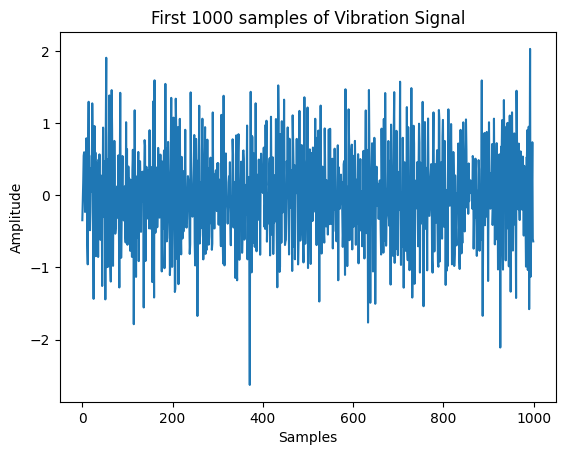

In [16]:
import scipy.io
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to your folder where .mat files are stored
data_folder = r"D:\ML PROJECTS\ball bearing damage prediction\HUST bearing dataset"

# List all files
files = os.listdir(data_folder)

# Find .mat files
mat_files = [f for f in files if f.endswith('.mat')]
print(f"Found {len(mat_files)} .mat files.")

# Load the first .mat file
mat_data = scipy.io.loadmat(os.path.join(data_folder, mat_files[0]))

# Check what keys are inside
print("Keys inside the .mat file:", mat_data.keys())

# Example: Assuming vibration data is stored under 'data'
# (change 'data' to correct key after checking keys printed)
data = mat_data['data']

# Plot first 1000 points
plt.plot(data[:1000])
plt.title("First 1000 samples of Vibration Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()



Total IMFs generated: 5


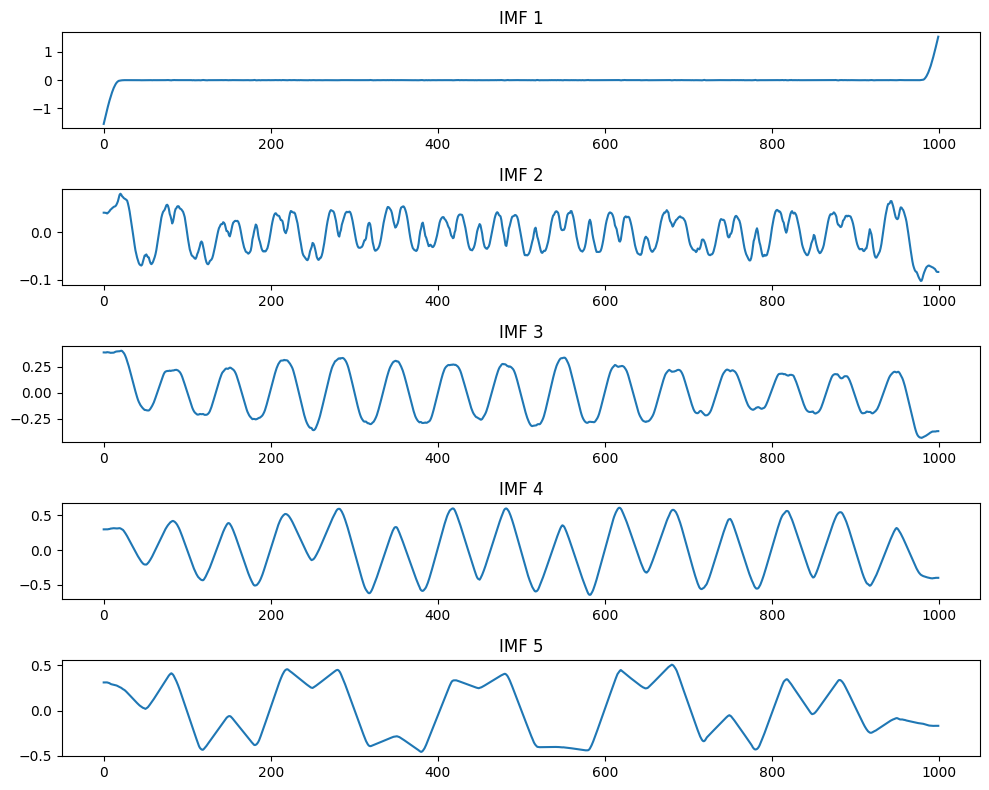

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, find_peaks

def simple_emd(signal, max_imfs=5):
    imfs = []
    residue = signal.copy()

    for _ in range(max_imfs):
        h = residue
        for _ in range(10):  # sifting iterations
            peaks, _ = find_peaks(h)
            troughs, _ = find_peaks(-h)

            if len(peaks) < 2 or len(troughs) < 2:
                break

            peak_env = np.interp(np.arange(len(h)), peaks, h[peaks])
            trough_env = np.interp(np.arange(len(h)), troughs, h[troughs])

            mean_env = (peak_env + trough_env) / 2
            h = h - mean_env

        imfs.append(h)
        residue = residue - h

    return np.array(imfs)

def simple_ceemdan(signal, noise_std=0.01, ensemble_size=100, max_imfs=5):
    all_imfs = []

    for _ in range(ensemble_size):
        noise = np.random.normal(0, noise_std, size=len(signal))
        noisy_signal = signal + noise
        imfs = simple_emd(noisy_signal, max_imfs=max_imfs)
        all_imfs.append(imfs)

    mean_imfs = np.mean(all_imfs, axis=0)
    return mean_imfs

# Example usage:

# Generate a sample signal
np.random.seed(0)
t = np.linspace(0, 1, 1000)
data = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 15 * t)

# Apply CEEMDAN
imfs = simple_ceemdan(data, noise_std=0.01, ensemble_size=50, max_imfs=5)

print(f"Total IMFs generated: {imfs.shape[0]}")

# Plot
fig, axs = plt.subplots(5, 1, figsize=(10, 8))
for i in range(5):
    axs[i].plot(imfs[i])
    axs[i].set_title(f'IMF {i+1}')
plt.tight_layout()
plt.show()


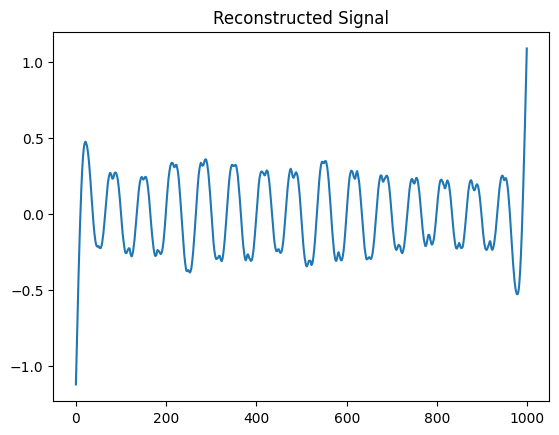

In [18]:
reconstructed = np.sum(imfs[:3], axis=0)  # Add first 3 IMFs
plt.plot(reconstructed)
plt.title('Reconstructed Signal')
plt.show()


In [19]:
from sklearn.metrics import mutual_info_score

def compute_mi(x, y, bins=30):
    # Binning the signals and computing mutual information
    x_binned = np.digitize(x, np.histogram_bin_edges(x, bins=bins))
    y_binned = np.digitize(y, np.histogram_bin_edges(y, bins=bins))
    return mutual_info_score(x_binned, y_binned)

# Compute reference MI (MI between original signal and random noise)

noise = np.random.normal(0, 1, len(data))
reference_mi = compute_mi(data, noise)
threshold = 1.5 * reference_mi  # 1.5 times reference MI for selection

# Select IMFs whose MI with the original signal is greater than the threshold
selected_imfs = []
for i in range(imfs.shape[0]):
    mi = compute_mi(imfs[i], data)
    if mi > threshold:
        selected_imfs.append(imfs[i])

# Convert the selected IMFs list back to numpy array
selected_imfs = np.array(selected_imfs)
print(f"Selected {selected_imfs.shape[0]} IMFs out of {imfs.shape[0]}")


Selected 4 IMFs out of 5


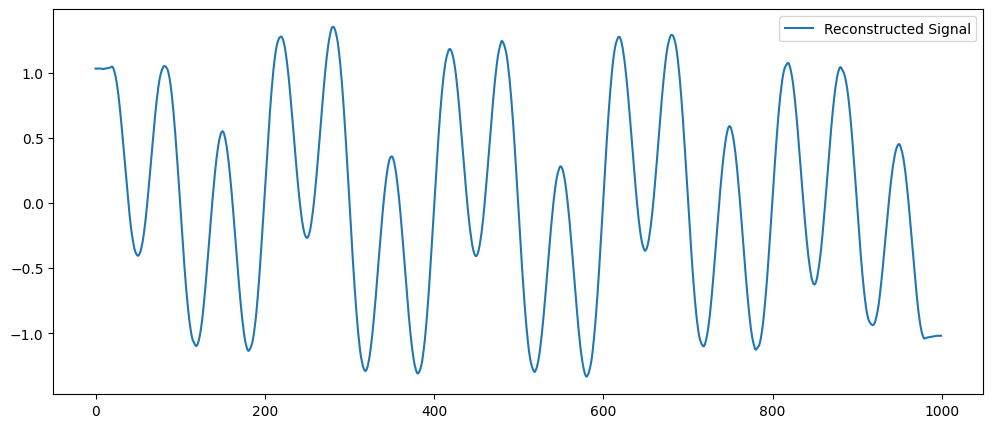

In [20]:
# Reconstruct signal by summing selected IMFs
reconstructed_signal = np.sum(selected_imfs, axis=0)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(reconstructed_signal, label="Reconstructed Signal")
plt.legend()
plt.show()


In [21]:
def ApEn(U, m, r):
    """Approximate Entropy"""
    def _phi(m):
        x = np.array([U[j:j+m] for j in range(len(U)-m+1)])
        C = np.sum(np.max(np.abs(x[:,None] - x[None,:]), axis=2) <= r, axis=0) / (len(U) - m + 1)
        return np.sum(np.log(C)) / (len(U) - m + 1)
    
    return abs(_phi(m) - _phi(m+1))


In [22]:
# Typical choice: m=2, r=0.2*std
m = 2
r = 0.2 * np.std(reconstructed_signal)

apen_value = ApEn(reconstructed_signal, m, r)
print(f"ApEn of Reconstructed Signal: {apen_value}")


ApEn of Reconstructed Signal: 0.32278034494700236


In [23]:
mean_apen = np.mean(reconstructed_signal)
std_apen = np.std(reconstructed_signal)

chebyshev_limit = mean_apen + 3 * std_apen  # 3-sigma rule

initial_failure_indices = np.where(reconstructed_signal > chebyshev_limit)[0]

if initial_failure_indices.size > 0:
    initial_failure_point = initial_failure_indices[0]
    print(f"Initial Failure Detected at index: {initial_failure_point}")
else:
    print("No initial failure detected using Chebyshev")


No initial failure detected using Chebyshev


In [24]:
# Look for sudden ApEn jump (basic version: simple diff)
apen_diff = np.diff(reconstructed_signal)

jump_threshold = np.mean(apen_diff) + 2 * np.std(apen_diff)
final_failure_indices = np.where(apen_diff > jump_threshold)[0]

if final_failure_indices.size > 0:
    final_failure_point = final_failure_indices[0]
    print(f"Final Failure Detected at index: {final_failure_point}")
else:
    print("No final failure detected using ApEn jump")


No final failure detected using ApEn jump


ApEn values computed over the signal.


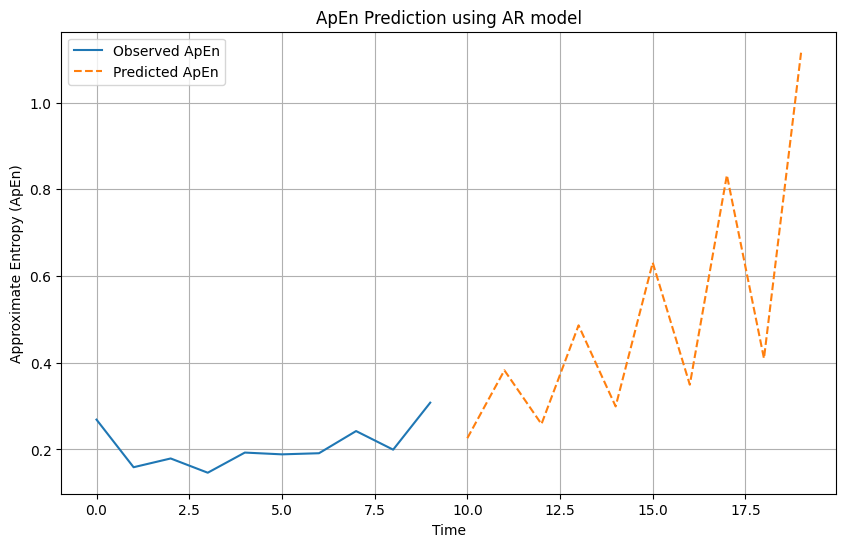

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# --- Step 1: Define the approximate_entropy function ---
def approximate_entropy(U, m, r):
    """Compute Approximate Entropy (ApEn) of sequence U."""
    def _phi(m):
        x = np.array([U[i:i+m] for i in range(len(U)-m+1)])
        C = np.sum(np.max(np.abs(x[:, None] - x[None, :]), axis=2) <= r, axis=0) / (len(U)-m+1)
        return np.sum(np.log(C)) / (len(U)-m+1)

    return abs(_phi(m) - _phi(m+1))

# --- Step 2: Calculate ApEn over sliding windows of the reconstructed signal ---
window_size = 100  # You can adjust this depending on your reconstructed signal size

apens = []
for i in range(0, len(reconstructed) - window_size + 1, window_size):
    window = reconstructed[i:i+window_size]
    apen = approximate_entropy(window, m=2, r=0.2*np.std(window))
    apens.append(apen)

apens = np.array(apens)

print("ApEn values computed over the signal.")

# --- Step 3: Fit AR model on the ApEn values ---
model = AutoReg(apens, lags=3)  # You can tune lag 3/4/5
model_fit = model.fit()

# --- Step 4: Predict next 10 steps ---
predictions = model_fit.predict(start=len(apens), end=len(apens)+9)

# --- Step 5: Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, len(apens)), apens, label='Observed ApEn')
plt.plot(np.arange(len(apens), len(apens)+10), predictions, label='Predicted ApEn', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Approximate Entropy (ApEn)')
plt.title('ApEn Prediction using AR model')
plt.legend()
plt.grid(True)
plt.show()



Best lag selected: 4


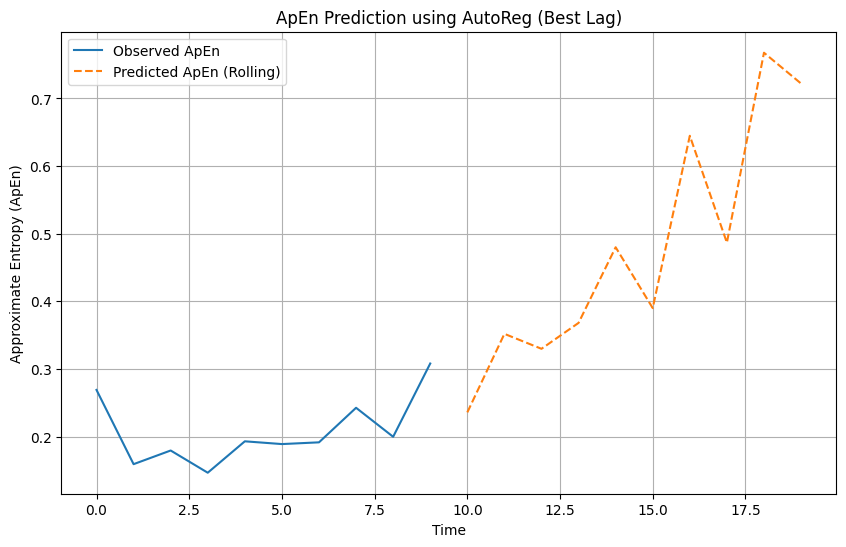

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Find the best lag based on AIC
best_aic = np.inf
best_lag = None
for lag in range(1, min(6, len(apens) // 2)):  # Test lags 1 to 5 (you can increase if you want)
    try:
        model = AutoReg(apens, lags=lag)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_lag = lag
    except Exception as e:
        continue  # In case of any error, skip

print(f"Best lag selected: {best_lag}")

# Fit model with best lag
model = AutoReg(apens, lags=best_lag)
model_fit = model.fit()

# Rolling prediction (predict one-by-one)
history = list(apens)
predictions = []

for _ in range(10):
    model = AutoReg(history, lags=best_lag)
    model_fit = model.fit()
    yhat = model_fit.predict(start=len(history), end=len(history))
    predictions.append(yhat[0])
    history.append(yhat[0])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, len(apens)), apens, label='Observed ApEn')
plt.plot(np.arange(len(apens), len(apens)+10), predictions, label='Predicted ApEn (Rolling)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Approximate Entropy (ApEn)')
plt.title('ApEn Prediction using AutoReg (Best Lag)')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import joblib

# Save the model
joblib.dump(model_fit, 'ap_en_model.pkl')


['ap_en_model.pkl']

In [35]:
from fastapi import FastAPI, UploadFile, File
import numpy as np
import joblib
from statsmodels.tsa.ar_model import AutoReg
import io
import pandas as pd

app = FastAPI()

# Load the saved model
model = joblib.load('ap_en_model.pkl')

@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    # Read uploaded file
    contents = await file.read()
    df = pd.read_csv(io.BytesIO(contents))
    
    # Assume the user uploads a CSV with 1 column: 'apen'
    apens = df['apen'].values.tolist()
    
    # Predict next 10 steps using rolling prediction
    history = list(apens)
    predictions = []
    lag = model.model.lags.max()  # Using original model lag

    for _ in range(10):
        new_model = AutoReg(history, lags=lag)
        new_model_fit = new_model.fit()
        yhat = new_model_fit.predict(start=len(history), end=len(history))
        predictions.append(yhat[0])
        history.append(yhat[0])

    return {"predictions": predictions}
